In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

### Preprocessing 

In [2]:
# df = pd.read_csv('/content/alzheimers_disease_data.csv')
# df = pd.read_csv('alzheimers_disease_data.csv')
df = pd.read_csv('/kaggle/input/alzheimers-disease-dataset/alzheimers_disease_data.csv')

df['Age'] = pd.cut(df['Age'],bins=[60,70,80,90],labels=['Younger','Old','Older'])
df['Ethnicity'] = df['Ethnicity'].map({0:'Caucasian',1:'African American',2:'Asian',3:'Other'})
df['EducationLevel'] = df['EducationLevel'].map({0:'None',1:'High School',2:"Bachelor's",3: 'Higher'})
df['Gender'] = df['Gender'].map({0:'Male',1:'Female'})
df = df.astype({'Ethnicity':'category','EducationLevel':'category','Gender':'category'})

df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,Old,Male,Caucasian,Bachelor's,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,Older,Male,Caucasian,None,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,Old,Male,Other,High School,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,Old,Female,Caucasian,High School,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,Older,Male,Caucasian,None,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


### Data Splitting 

In [3]:
X = df.drop(columns=['PatientID','DoctorInCharge','Diagnosis'])
y = df.Diagnosis

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y,shuffle=True)

In [4]:
from sklearn.impute import SimpleImputer

numeric_col = X_train.select_dtypes(exclude=['category']).columns.tolist()

num = Pipeline([
    ('scl',StandardScaler())
])

cat = Pipeline([
    ('imp',SimpleImputer(strategy='most_frequent')),
    ('enc',OneHotEncoder())
])

preprcessor = ColumnTransformer([
    ('num',num,numeric_col),
    ('cat',cat,['Age','Gender','Ethnicity','EducationLevel'])
])

### Model Selection 

In [5]:
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

models = [
      ('Logistic Regression', LogisticRegression()),
      ('K-Nearest Neighbors', KNeighborsClassifier()),
      ('Support Vector Machines', SVC()),
      ('Decision Tree', DecisionTreeClassifier()),
      ('Random Forest', RandomForestClassifier()),
      ('AdaBoost', AdaBoostClassifier()),
      ('Gradient Boosting', GradientBoostingClassifier()),
      ('Naive Bayes', GaussianNB()),
      ('Neural Network', MLPClassifier()),
      ('XGB', XGBClassifier())
]

results = []

for name, model in models:
    pipeline = Pipeline([
      ('prep',preprcessor),
      ('model',model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([name, accuracy, precision, recall, f1])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy','Precision', 'Recall', 'F1 Score'])
results_df

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.823256,0.753333,0.743421,0.748344
1,K-Nearest Neighbors,0.725581,0.657407,0.467105,0.546154
2,Support Vector Machines,0.837209,0.788732,0.736842,0.761905
3,Decision Tree,0.895349,0.845161,0.861842,0.853420
4,Random Forest,0.932558,0.936170,0.868421,0.901024
5,AdaBoost,0.886047,0.841060,0.835526,0.838284
6,Gradient Boosting,0.944186,0.921053,0.921053,0.921053
7,Naive Bayes,0.748837,0.634146,0.684211,0.658228
8,Neural Network,0.800000,0.726027,0.697368,0.711409
9,XGB,0.948837,0.939189,0.914474,0.926667


### Model Evaluation

In [6]:
pipeline = Pipeline([
      ('prep',preprcessor),
      ('model',XGBClassifier())
  ])

pipeline.fit(X_train,y_train)
print(pipeline.score(X_train,y_train),pipeline.score(X_test,y_test))

1.0 0.9488372093023256


In [12]:
from skopt import BayesSearchCV
from skopt.space import Real,Integer

pipeline = Pipeline([
      ('prep',preprcessor),
      ('model',XGBClassifier(use_label_encoder=False))
  ])

param = {
    'model__n_estimators':Integer(100,300),
    'model__learning_rate':Real(0.001,1),
    'model__max_depth':Integer(3,6),
    'model__gamma': Real(0.01,0.2),
    'model__reg_alpha': Real(0.1,0.5),
    'model__reg_lambda': Real(1, 2)
}

model = BayesSearchCV(pipeline,param,cv=3,n_iter=30,scoring='accuracy',verbose=1,n_jobs=-1) 
model.fit(X_train,y_train)

print(f"Train Score: {model.score(X_train,y_train)},\nTest Score: {model.score(X_test,y_test)},\nBest Score: {model.best_score_},\nBest Params: {model.best_params_}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

0.9488372093023256
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1       0.94      0.91      0.93       152

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.94       430
weighted avg       0.95      0.95      0.95       430



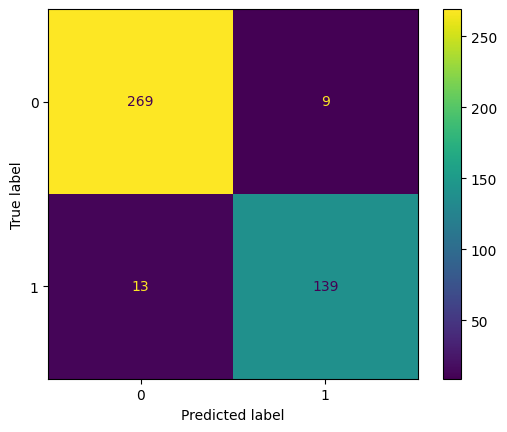

In [16]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt

ypred = model.predict(X_test)
conf_mat = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=model.classes_)
disp.plot();

print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))